In [1]:
%cd ~/google_drive/code/projects/sparse/python
from sparse.core.sparse_dataframe import SparseDataFrame
from sparse.utilities.utils import *

%cd ~/google_drive/code/projects/texture_classifier/python
# %cd /home/ubuntu/texture_classifier/python
import multiprocessing
import PIL
from sklearn.cluster import KMeans
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import cv2
from pandas.io.pytables import HDFStore
# from plotly import plotly
# from plotly.graph_objs import *

import core.utils
reload(core.utils)
from core.utils import *

import core.image_scanner
reload(core.image_scanner)
from core.image_scanner import ImageScanner

import core.pipeline
reload(core.pipeline)
from core.pipeline import *

/Users/alexbraun/google_drive/code/projects/sparse/python
/Users/alexbraun/google_drive/code/projects/texture_classifier/python


In [ ]:
info = os.listdir('/Users/alexbraun/Downloads/data/arroway_wood/data')
info = filter(lambda x: re.search('diffuse', x), info)
info = filter(lambda x: re.search('_a_', x), info)
info = map(lambda x: re.search('.*_(.*)_diffuse', x).group(1), info)
info = sorted(info)
idwood = pd.read_csv('/Users/alexbraun/google_drive/code/projects/texture_classifier/data/identifying_wood_data.csv')

temp = list(set(list(chain(*map(lambda x: x.split('-'), info)))))
def has_keyword(item):
    output = []
    for regex in temp:
        found = re.search(regex, item, re.IGNORECASE)
        if found:
            output.append(found.group(0))
    if output:
        return ' '.join(output)
    return False
    
for col in ['common_name']:#, 'scientific_name']:
    new_col = 'found_' + col
    idwood[new_col] = None
    idwood[new_col] = idwood[col].apply(has_keyword)
    
x = idwood[(idwood.found_common_name != False)]# | (idwood.found_scientific_name != False)]

In [ ]:
sci = x[x.found_scientific_name != False].index
# x.found_scientific_name.tolist()

In [ ]:
mask = x.found_common_name.apply(lambda x: x not in ['fir', 'cedar', 'white', 'black', 'red'])
x = x[mask][['common_name', 'found_common_name']]

In [26]:
# %%snakeviz
%cd /Users/alexbraun/google_drive/code/projects/texture_classifier/python 
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedShuffleSplit, ShuffleSplit
import pickle
import core.image_scanner
reload(core.image_scanner)
from core.image_scanner import ImageScanner

import core.utils
reload(core.utils)
from core.utils import *

# root = '/Volumes/abraun.backup.01/project folders/texture_classifier/data'
root = '/Users/alexbraun/Documents/data/texture_classifier/data/msgpack'
%cd /Users/alexbraun/Documents/data/texture_classifier/data/msgpack

# spec = ['texture', 'image_id', 'image_class', 'common_name', 'pass_', 'extension']
# info = get_series_info(root, spec)
info = pd.read_pickle('/Users/alexbraun/Documents/data/texture_classifier/data/info.pkl')
info = info[(info.image_class == 'a') & (info.pass_ == 'diffuse')]
# info = info.head()

patches = 1000

y = Series(info.index).apply(lambda x: [x]) * patches
y = list(chain(*y.tolist()))
y = Series(y)

params = {
            'aspect_ratio':     1,
            'min_size':         0.05,
            'max_size':         0.1,
            'patches':          patches,
            'patch_resolution': (100, 100),
            'rotation':         'random'
}

data = []
for file_ in info.fullpath:
    data.append(pd.read_msgpack(file_))
    
data = pd.concat(data, axis=0)
data['y'] = y

# index = data.index
# np.random.shuffle(index.tolist())
# data = data.ix[index]

# data = data.head(10000)

# X = data.drop('y', axis=1)
# y = data['y']

# index = data.index.tolist()
# np.random.shuffle(index)
# data.index = index
# X = np.array(data.ix[index])

# data.to_msgpack('../random_scan.100.100x100.05-10.random.msgpack')
# shuffle data
# index = data.index.tolist()
# np.random.shuffle(index)
# data = data.ix[index]

# with open('../random_scan.1000.100x100.05-10.random.pkl', 'w') as pkl:
#     pickle.dump(data, pkl)


/Users/alexbraun/google_drive/code/projects/texture_classifier/python
/Users/alexbraun/Documents/data/texture_classifier/data/msgpack


In [14]:
clf = RandomForestClassifier()
params = {
    'n_estimators':        [10],
#     'criterion':'          gini',
#     'max_depth':           None,
#     'min_samples_split':   2,
#     'min_samples_leaf':    1,
#     'max_features':'       'auto',
#     'max_leaf_nodes':      None,
#     'bootstrap':           True,
#     'oob_score':           False,
    'n_jobs':              [-1]
#     'random_state':        None,
#     'verbose':             0,
#     'min_density':         None,
#     'compute_importances': None
}
# train, test = [x for x in StratifiedShuffleSplit(y, n_iter=1, test_size=0.2)][0]
# train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)
grid = GridSearchCV(clf, params)
# %time grid.fit(X.ix[test], y.ix[test])
# print(grid.best_score_)
# print(grid.best_estimator_.score(X.ix[test], y.ix[test]))

In [7]:
def batch(info, hdf_path):
    info.reset_index(drop=True, inplace=True)
    n = info.shape[0]
    indices = range(0, n, processes)
    indices.append(n)
    indices = zip(indices, indices[1:])
    
    batch_path = os.path.join(hdf_path, '.batch')
    os.mkdir(hdf_path)
    
    for i, (start, stop) in enumerate(indices):       
        pool = multiprocessing.Pool(processes=processes)
        
        batch = info.ix[range(star, stop + 1)]
        iterable = [(row.to_frame().T, features) for i, row in batch.iterrows()]
        data = pool.map(_multi_get_data, iterable)
        pool.close()
        
        data = pd.concat(data, axis=0)
        filename = 'data.' + str(i).zfill(4) + '.hdf.batch'
        hdf = HDFStore(os.path.join(batch_path, filename))
        hdf['data'] = data
        hdf.close()
        
        print('indices {:<10} - {:<10} written to {:<}'.format(start, stop, filename))
    
    batch = filter(lambda x: '.hdf.batch' in x, os.listdir(batch_path))
    batch = map(os.path.abspath, batch)
    data = [pd.read_hdf(x, 'data') for x in batch]
    data = pd.concat(data, axis=0, ignore_index=True)
    
    # shuffle data to destroy serial correlations
    index = data.index.tolist()
    np.random.shuffle(index)
    data = data.ix[index]
    data.reset_index(drop=True, inplace=True)   
    
    hdf = HDFStore(os.join(hdf_path, 'data.hdf')
    hdf['data'] = data
    hdf.close()

[(0, 24), (24, 48), (48, 72), (72, 96), (96, 100)]

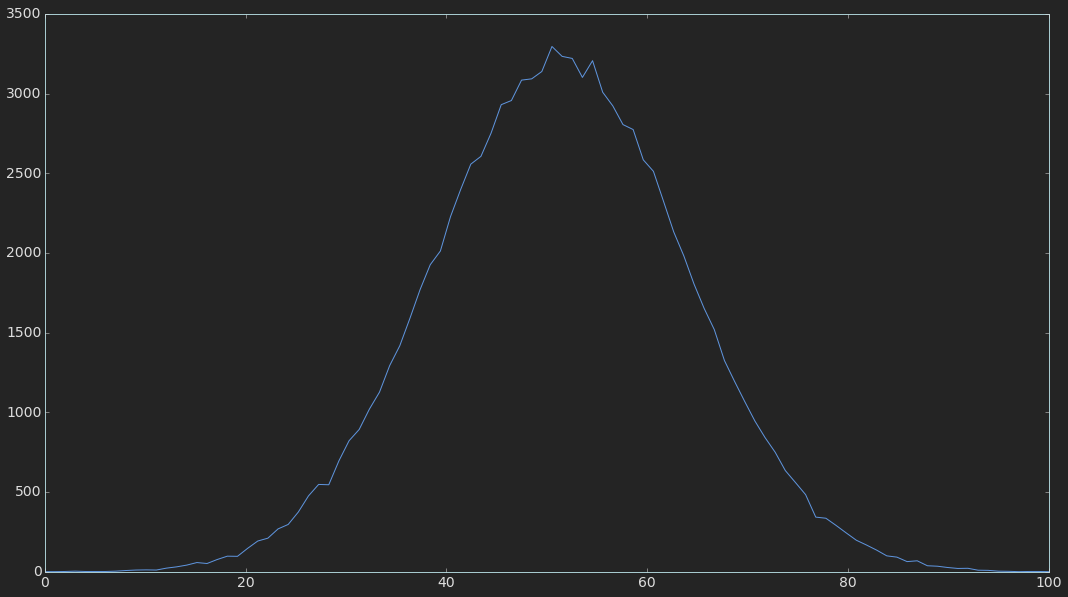

In [13]:
x = np.linspace(0, 100, 100)
y, _ = np.histogram(np.random.normal(size=100000), 100)
plt.plot(x, y)

In [ ]:
# source = '/Users/alexbraun/google_drive/code/projects/texture_classifier/web/upload/'
# spec = ['name', 'source_extension']
# get_info(source, spec)

